# Практична 8 — Класифікація згідно умови (варіант 6)

Завдання: створити набір даних для задачі класифікації за допомогою `make_classification` з такими правилами:
- кількість зразків: `1000 * [номер за журналом]`;
- кількість класів: `[номер за журналом] + 2`.

У цьому прикладі номер у журналі = **7**, отже:
- `n_samples = 1000 * 6 = 7000`
- `n_classes = 6 + 2 = 8`.

Далі ми: (1) згенеруємо дані, (2) підготуємо їх (спліт + масштабування), (3) побудуємо просту нейронну мережу на Keras із Softmax-виходом, (4) навчимо та (5) оцінимо якість (accuracy, звіт класифікації, матриця плутанини).


## 1. Параметри варіанту та інсталяції
- Встановлюємо `student_number = 7`.
- Автоматично обчислюємо `n_samples` та `n_classes` за формулою з умови.
- За потреби — інсталюємо залежності (рядок лишено закоментованим).


In [1]:
# Якщо бракує бібліотек — розкоментуйте і виконайте наступний рядок.
# %pip install scikit-learn matplotlib seaborn tensorflow pandas

student_number = 7
RANDOM_STATE = student_number

# Згідно умови завдання
N_SAMPLES = 1000 * student_number   # 7000
N_CLASSES = student_number + 2      # 9

# Інші налаштування (раціональні за замовчуванням)
TEST_SIZE = 0.2
N_FEATURES = max(12, 2 * N_CLASSES)  # достатньо ознак для 9 класів (мінімум 18)
CLASS_SEP = 1.5 + 0.1 * (student_number % 5)  # невелика варіація відокремленості класів

N_SAMPLES, N_CLASSES, N_FEATURES, CLASS_SEP


(7000, 9, 18, 1.7)

## 2. Імпорт бібліотек
Імпортуємо інструменти для генерації даних, підготовки, моделювання та оцінювання.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
sns.set(style='whitegrid', context='notebook')


## 3. Генерація та підготовка даних (мультиклас)
Генеруємо дані з девʼятьма класами, щоб моделювати мультикласову класифікацію.
- Вибираємо кількість інформативних ознак так, щоб модель мала достатньо сигналу; решту робимо надлишковими.
- Розбиваємо дані на train/test із стратифікацією.
- Масштабуємо ознаки для стабільнішого навчання мережі.


In [3]:
# Вибір кількості інформативних та надлишкових фіч
n_informative = min(N_FEATURES, 8)   # залишимо 8 інформативних для 9 класів
n_redundant  = max(0, N_FEATURES - n_informative)

X, y = make_classification(
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=N_CLASSES,
    n_clusters_per_class=1,
    class_sep=CLASS_SEP,
    flip_y=0.01,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_s.shape, X_test_s.shape, y_train.shape, y_test.shape, np.unique(y)


((5600, 18), (1400, 18), (5600,), (1400,), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

## 4. Модель (Keras, Softmax)
- Вихідний шар має розмір `N_CLASSES` та `softmax`-активацію.
- Використовуємо `sparse_categorical_crossentropy`, щоб не виконувати one-hot кодування.
- Метрика — `accuracy`.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,593 (14.04 KB)

 Trainable params: 3,593 (14.04 KB)

 Non-trainable params: 0 (0.00 B)

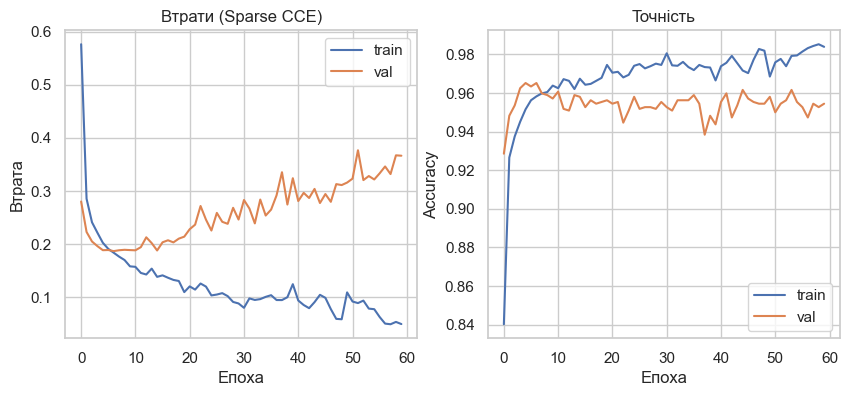

In [4]:
clf = Sequential([
    Input(shape=(N_FEATURES,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(N_CLASSES, activation='softmax')
])
clf.compile(optimizer=Adam(learning_rate=0.01),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
clf.summary()

history = clf.fit(
    X_train_s, y_train,
    epochs=60, batch_size=64,
    validation_split=0.2, verbose=0
)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[0].set_title('Втрати (Sparse CCE)')
ax[0].set_xlabel('Епоха'); ax[0].set_ylabel('Втрата'); ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='val')
ax[1].set_title('Точність')
ax[1].set_xlabel('Епоха'); ax[1].set_ylabel('Accuracy'); ax[1].legend();


## 5. Оцінка якості
- Обчислюємо точність на тесті.
- Будуємо матрицю плутанини.
- Друкуємо докладний `classification_report` зі значеннями precision/recall/F1 по класах.


Test Accuracy: 0.952


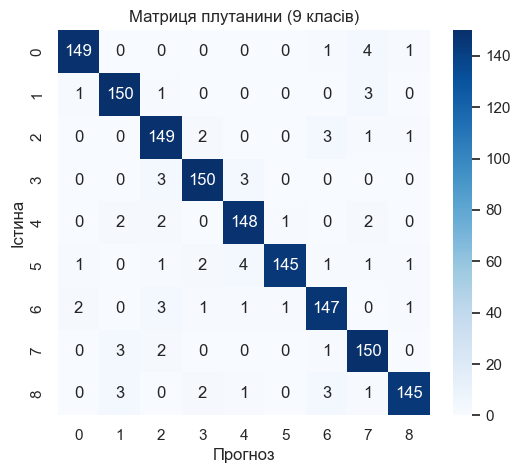

              precision    recall  f1-score   support

           0      0.974     0.961     0.968       155
           1      0.949     0.968     0.958       155
           2      0.925     0.955     0.940       156
           3      0.955     0.962     0.958       156
           4      0.943     0.955     0.949       155
           5      0.986     0.929     0.957       156
           6      0.942     0.942     0.942       156
           7      0.926     0.962     0.943       156
           8      0.973     0.935     0.954       155

    accuracy                          0.952      1400
   macro avg      0.953     0.952     0.952      1400
weighted avg      0.953     0.952     0.952      1400



In [5]:
y_proba = clf.predict(X_test_s, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {acc:.3f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця плутанини (9 класів)')
plt.xlabel('Прогноз'); plt.ylabel('Істина');
plt.show()

print(classification_report(y_test, y_pred, digits=3))


## 6. Висновки
- Дані згенеровано рівно за умовою: `n_samples=7000`, `n_classes=9`.
- Модель — простий MLP із Softmax-виходом; достатній базовий підхід для такої синтетики.
- За потреби можна збільшити глибину мережі, додати регуляризацію або змінити `CLASS_SEP`, щоб дослідити вплив складності задачі.


## 7. Усунення перетренування (Regularization + EarlyStopping)
- Додаємо Dropout і L2-регуляризацію до шару.
- Використовуємо EarlyStopping з відновленням найкращих ваг та ReduceLROnPlateau.


In [6]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5)


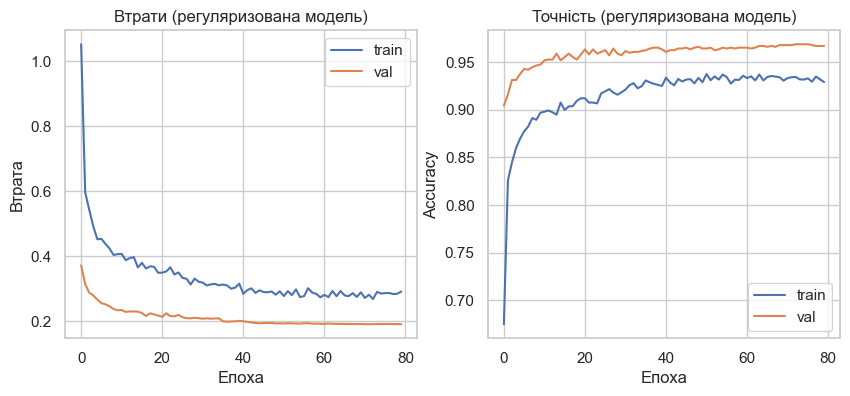

In [7]:
# Регуляризована модель з Dropout + L2
clf_reg = Sequential([
    Input(shape=(N_FEATURES,)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(N_CLASSES, activation='softmax')
])
clf_reg.compile(optimizer=Adam(learning_rate=0.005),
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = clf_reg.fit(
    X_train_s, y_train,
    epochs=120, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history2.history['loss'], label='train')
ax[0].plot(history2.history['val_loss'], label='val')
ax[0].set_title('Втрати (регуляризована модель)')
ax[0].set_xlabel('Епоха'); ax[0].set_ylabel('Втрата'); ax[0].legend()

ax[1].plot(history2.history['accuracy'], label='train')
ax[1].plot(history2.history['val_accuracy'], label='val')
ax[1].set_title('Точність (регуляризована модель)')
ax[1].set_xlabel('Епоха'); ax[1].set_ylabel('Accuracy'); ax[1].legend();


Test Accuracy (регуляризована модель): 0.962


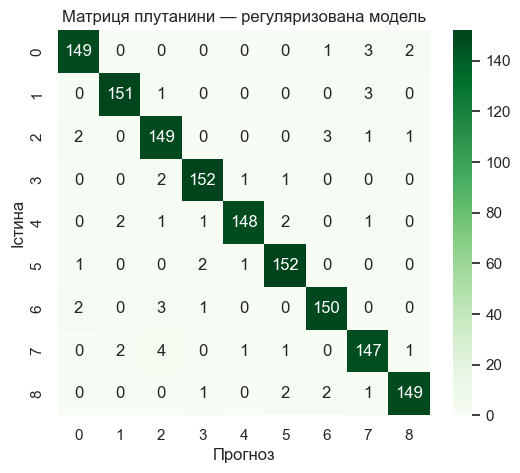

              precision    recall  f1-score   support

           0      0.968     0.961     0.964       155
           1      0.974     0.974     0.974       155
           2      0.931     0.955     0.943       156
           3      0.968     0.974     0.971       156
           4      0.980     0.955     0.967       155
           5      0.962     0.974     0.968       156
           6      0.962     0.962     0.962       156
           7      0.942     0.942     0.942       156
           8      0.974     0.961     0.968       155

    accuracy                          0.962      1400
   macro avg      0.962     0.962     0.962      1400
weighted avg      0.962     0.962     0.962      1400



In [8]:
y_proba_reg = clf_reg.predict(X_test_s, verbose=0)
y_pred_reg = np.argmax(y_proba_reg, axis=1)
acc_reg = accuracy_score(y_test, y_pred_reg)
print(f'Test Accuracy (регуляризована модель): {acc_reg:.3f}')

cm_reg = confusion_matrix(y_test, y_pred_reg)
plt.figure(figsize=(6,5))
sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Greens')
plt.title('Матриця плутанини — регуляризована модель')
plt.xlabel('Прогноз'); plt.ylabel('Істина');
plt.show()

print(classification_report(y_test, y_pred_reg, digits=3))
